In [1]:
num_epochs = 50

In [2]:
# Import the data for each company
import pandas as pd

#Empresa
df = pd.read_csv('GFINBURO.csv')
df

#Define the target
target = "Cierre"

df = df.drop(['Fecha','% var.','Vol.'], axis=1)
df

,Cierre,Apertura,Máximo,Mínimo
0,44.36,44.09,44.53,43.69
1,43.96,43.65,44.12,43.16
2,43.08,43.75,44.67,42.83
3,43.64,43.56,44.10,42.82
4,43.85,44.21,45.00,43.58
...,...,...,...,...
1143,24.11,24.16,24.90,23.90
1144,24.22,24.67,24.67,23.90
1145,24.83,24.35,24.92,24.33
1146,24.56,24.30,24.70,24.15


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epochs):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 4.775678949179938
Test accuracy: 0.20939430596193775

Epoch 0
---------
Train loss: 0.8190740257279094
Train accuracy: 1.22089072110696
Test loss: 2.8847793340682983
Test accuracy: 0.34664695268911316
Epoch 1
---------
Train loss: 0.36960869686739817
Train accuracy: 2.705563310385068
Test loss: 1.0084702065484819
Test accuracy: 0.991600836937409
Epoch 2
---------
Train loss: 0.11119952852891715
Train accuracy: 8.992835796568805
Test loss: 0.2783337004395379
Test accuracy: 3.592808341713527
Epoch 3
---------
Train loss: 0.057349679853449256
Train accuracy: 17.43685856432901
Test loss: 0.15175285570628788
Test accuracy: 6.58965748209519
Epoch 4
---------
Train loss: 0.040438471126698426
Train accuracy: 24.728865836206023
Test loss: 0.1031651071990582
Test accuracy: 9.693190438424564
Epoch 5
---------
Train loss: 0.028972911013465524
Train accuracy: 34.51488005631307
Test loss: 0.09222168422525581
Test accuracy: 10.84342499335575
Epoch 6
---------
Train 

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelINBURSA" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Cierre  Model forecast
0      44.36       44.233311
1      43.96       43.877586
2      43.08       43.428802
3      43.64       43.597534
4      43.85       43.986160
...      ...             ...
1143   24.11       24.232464
1144   24.22       24.233372
1145   24.83       24.531382
1146   24.56       24.516739
1147   24.62       24.347691

[1149 rows x 2 columns]


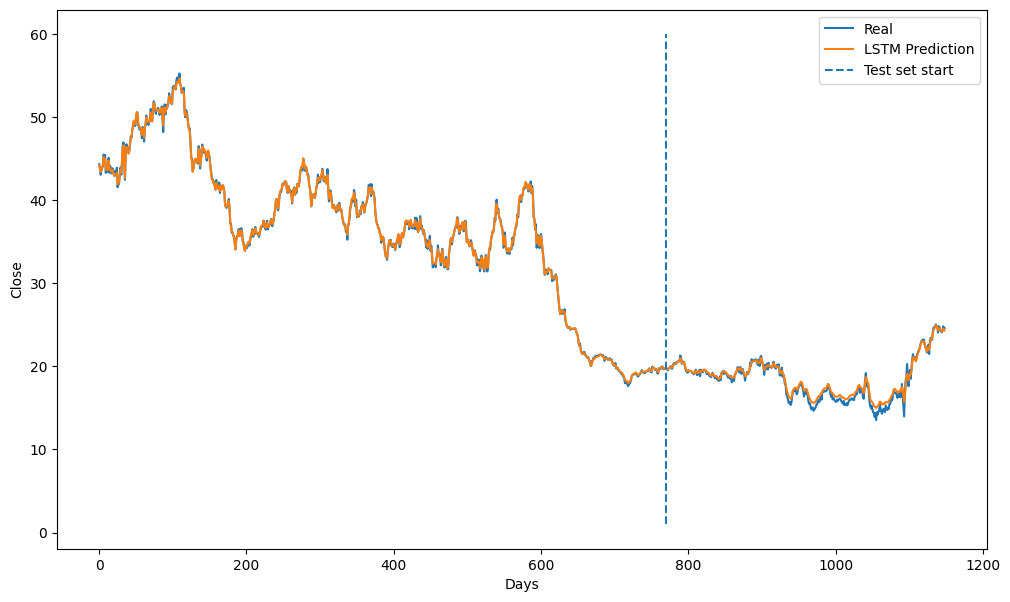

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

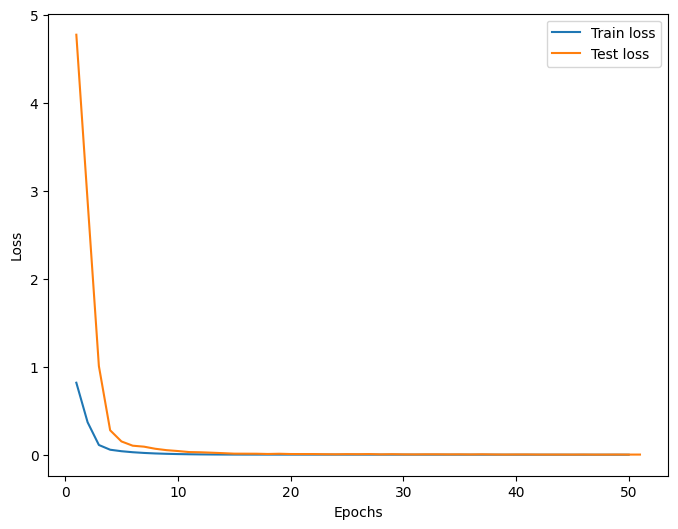

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [15]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 3.926892392553566
Test accuracy: 0.25465428500939774
Execution time 16.678096055984497
Epoch 0
---------
Train loss: 0.10161655460998784
Train accuracy: 9.840906530903553
Test loss: 0.047434383770724516
Test accuracy: 21.081709349542393
Execution time 78.41376376152039
Epoch 1
---------
Train loss: 0.004088687349096355
Train accuracy: 244.5712908549782
Test loss: 0.027665253899695503
Test accuracy: 36.14629343349938
Execution time 78.2259566783905
Epoch 2
---------
Train loss: 0.0028302455153833297
Train accuracy: 353.31375429779087
Test loss: 0.021097025767491655
Test accuracy: 47.39982171130106
Execution time 78.40455555915833
Epoch 3
---------
Train loss: 0.0022145914824509287
Train accuracy: 451.53016026111766
Test loss: 0.017197421154857923
Test accuracy: 58.14791509749194
Execution time 78.38274431228638
Epoch 4
---------
Train loss: 0.0018102496647619598
Train accuracy: 552.3794764430155
Test loss: 0.01278855746046575
Test accuracy: 78.19429076

In [16]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelINBURSA" )

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Cierre  Model forecast
0      44.36       44.389175
1      43.96       43.987213
2      43.08       43.154327
3      43.64       43.643009
4      43.85       43.904232
...      ...             ...
1143   24.11       24.149796
1144   24.22       24.240360
1145   24.83       24.927584
1146   24.56       24.557411
1147   24.62       24.691700

[1149 rows x 2 columns]


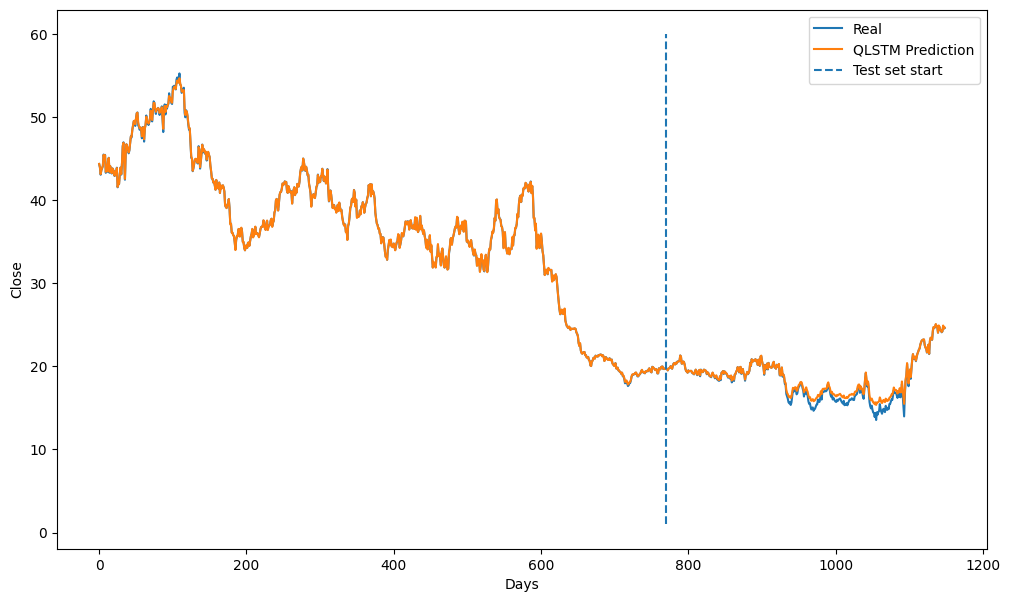

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

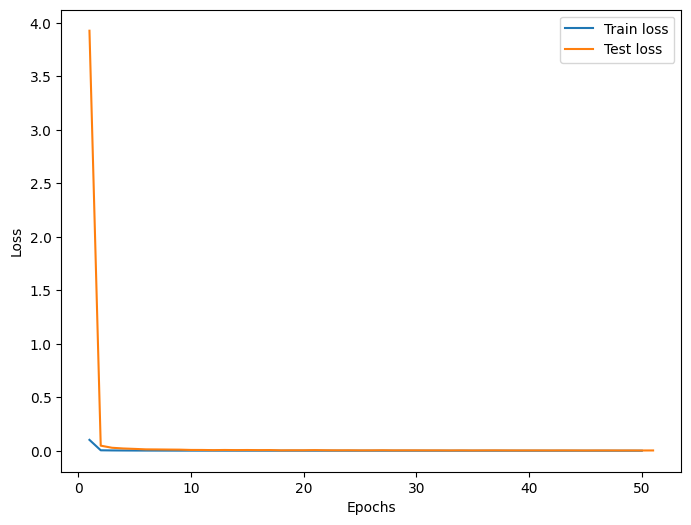

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

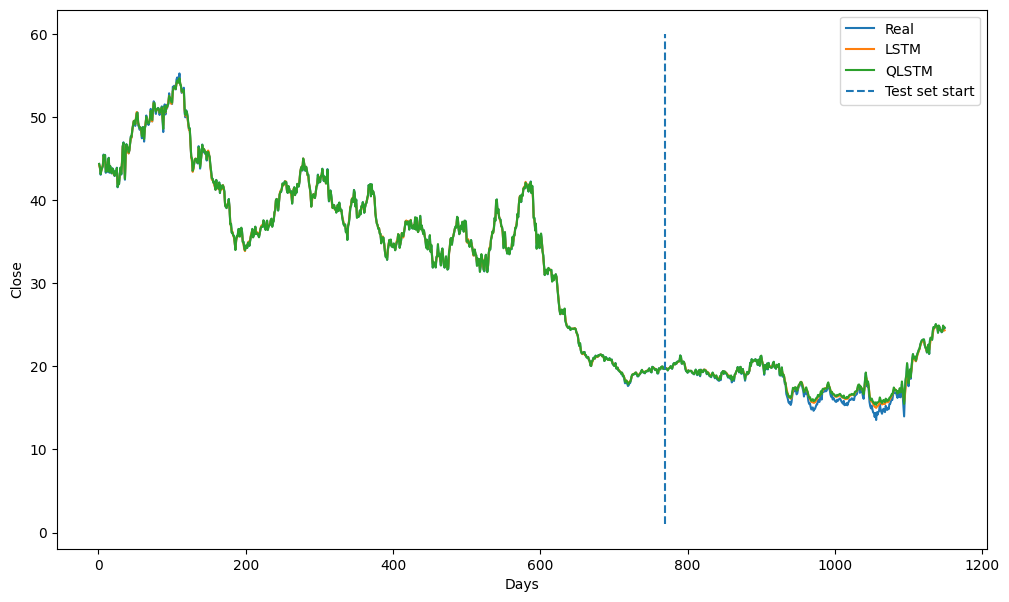

In [23]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1, len(df) + 2), df_out["Model forecast"], label = "LSTM")
plt.plot(range(1, len(df) + 2), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()